In [1]:
import os
import json
from typing import List, Tuple, Optional
import numpy as np
import json, os, numpy as np, matplotlib.pyplot as plt

FINETUNE_JSON = "retina_finetune_epoch_metrics.json"
PRETRAIN_JSON = "retina_pretrain_epoch_metrics.json"

plt.rcParams["figure.dpi"] = 120

In [3]:
def load_metrics(path):
    with open(path, "r") as f:
        data = json.load(f)
    # sort by epoch if exists
    try:
        data = sorted(data, key=lambda d: (d.get("epoch", 0) if d.get("epoch") is not None else 0))
    except Exception:
        pass
    return data

def _extract_series(metrics, key):
    """Return epochs, values (floats with NaNs for missing)."""
    epochs, vals = [], []
    for m in metrics:
        e = m.get("epoch", np.nan)
        v = m.get(key, np.nan)
        if v is None: v = np.nan
        epochs.append(float(e) if e is not None else np.nan)
        vals.append(float(v) if isinstance(v, (int, float)) else np.nan)
    return np.array(epochs, float), np.array(vals, float)

def extract_auc(metrics, kind):
    """
    Returns epochs, mean, std for {sex,bmi,age}.
    Falls back to std computed from per-fold list if *_auc_std missing.
    """
    ep, mean = _extract_series(metrics, f"{kind}_auc")
    _, std = _extract_series(metrics, f"{kind}_auc_std")
    out_std = []
    for m, s, entry in zip(mean, std, metrics):
        if np.isnan(m):
            out_std.append(np.nan)
            continue
        if not np.isnan(s):
            out_std.append(s)
            continue
        folds = entry.get(f"{kind}_aucs", None)
        if isinstance(folds, list) and len(folds) > 1:
            try: out_std.append(float(np.std(np.array(folds, float))))
            except: out_std.append(np.nan)
        else:
            out_std.append(np.nan)
    return ep, mean, np.array(out_std, float)

def plot_auc_all(metrics, title_prefix=""):
    for kind in ("sex","bmi","age"):
        ep, mean, std = extract_auc(metrics, kind)
        mask = ~np.isnan(ep) & ~np.isnan(mean)
        plt.figure()
        if mask.any():
            plt.errorbar(ep[mask], mean[mask], yerr=(std[mask] if std is not None else None), fmt="o-")
        plt.xlabel("Epoch"); plt.ylabel(f"{kind.upper()} AUC")
        plt.title(f"{title_prefix} {kind.upper()} AUC per epoch")
        plt.grid(True)
        plt.show()

def plot_mse(metrics, is_finetune=True, title_prefix=""):
    # keys differ between pretrain and finetune
    tr_key, va_key = ("train_mse_mean","val_mse_mean") if is_finetune else ("train_mse","val_mse")
    ep = np.array([m.get("epoch", np.nan) for m in metrics], float)
    _, tr = _extract_series(metrics, tr_key)
    _, va = _extract_series(metrics, va_key)

    if np.all(np.isnan(tr)) and np.all(np.isnan(va)):
        print("No MSE data found; skipping.")
        return
    plt.figure()
    if (~np.isnan(tr)).any(): plt.plot(ep[~np.isnan(tr)], tr[~np.isnan(tr)], "o-", label="Train MSE")
    if (~np.isnan(va)).any(): plt.plot(ep[~np.isnan(va)], va[~np.isnan(va)], "o-", label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title(f"{title_prefix} MSE per epoch")
    plt.grid(True); plt.legend(); plt.show()

def plot_r2(metrics, title_prefix=""):
    """
    Preferred: train_r2_mean / val_r2_mean per epoch.
    Fallback: average val_r2 from 'top5_features_by_val_mse' list.
    """
    ep, tr = _extract_series(metrics, "train_r2_mean")
    _,  va  = _extract_series(metrics, "val_r2_mean")

    have_pref = not (np.all(np.isnan(tr)) and np.all(np.isnan(va)))
    if not have_pref:
        epochs, val_top5 = [], []
        for m in metrics:
            e = m.get("epoch", np.nan)
            lst = m.get("top5_features_by_val_mse", [])
            vals = []
            if isinstance(lst, list):
                for item in lst:
                    v = item.get("val_r2", None)
                    if isinstance(v, (int, float)): vals.append(float(v))
            if len(vals) > 0:
                epochs.append(float(e) if e is not None else np.nan)
                val_top5.append(float(np.mean(vals)))
        if len(val_top5) == 0:
            print("No R² data found; skipping.")
            return
        ep = np.array(epochs, float)
        tr = np.full_like(ep, np.nan, float)
        va = np.array(val_top5, float)

    plt.figure()
    if (~np.isnan(tr)).any(): plt.plot(ep[~np.isnan(tr)], tr[~np.isnan(tr)], "o-", label="Train R²")
    if (~np.isnan(va)).any(): plt.plot(ep[~np.isnan(va)], va[~np.isnan(va)], "o-", label="Val R²")
    plt.xlabel("Epoch"); plt.ylabel("R²"); plt.title(f"{title_prefix} R² per epoch")
    plt.grid(True); plt.legend(); plt.show()


In [4]:
fin_metrics = load_metrics(FINETUNE_JSON) if os.path.exists(FINETUNE_JSON) else []
pre_metrics = load_metrics(PRETRAIN_JSON) if os.path.exists(PRETRAIN_JSON) else []

print(f"Finetune epochs: {len(fin_metrics)} entries")
print(f"Pretrain epochs: {len(pre_metrics)} entries")

# Peek at the first item to confirm shape:
if fin_metrics: print("Finetune[0] keys:", list(fin_metrics[0].keys())[:12], "...")
if pre_metrics: print("Pretrain[0] keys:", list(pre_metrics[0].keys())[:12], "...")


Finetune epochs: 4 entries
Pretrain epochs: 3 entries
Finetune[0] keys: ['epoch', 'train_mse_mean', 'val_mse_mean', 'top5_features_by_val_mse', 'sex_auc', 'sex_auc_std', 'sex_aucs', 'sex_n', 'sex_pos_rate', 'bmi_auc', 'bmi_auc_std', 'bmi_aucs'] ...
Pretrain[0] keys: ['epoch', 'train_mse', 'val_mse', 'sex_auc', 'sex_auc_std', 'sex_aucs', 'sex_n', 'sex_pos_rate', 'bmi_auc', 'bmi_auc_std', 'bmi_aucs', 'bmi_n'] ...


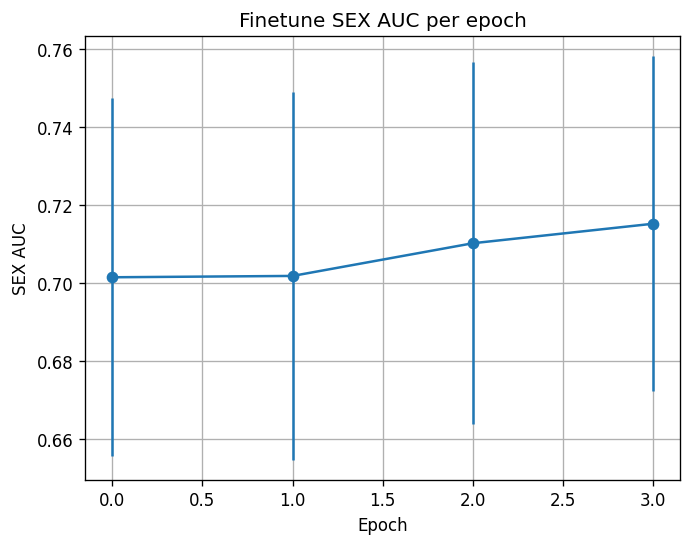

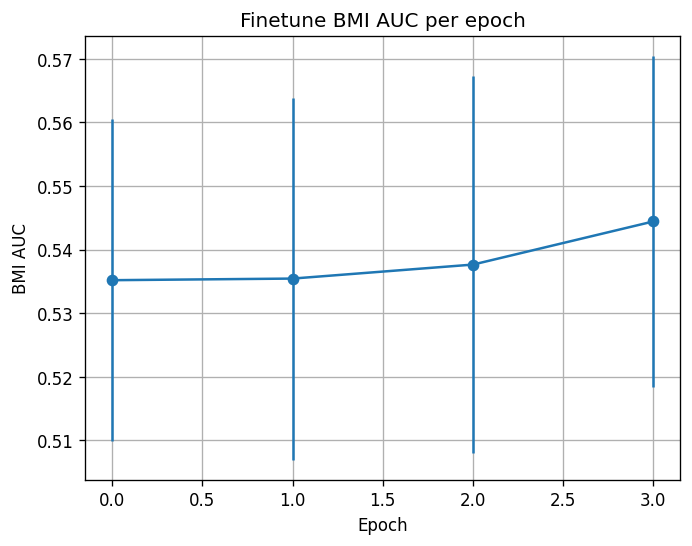

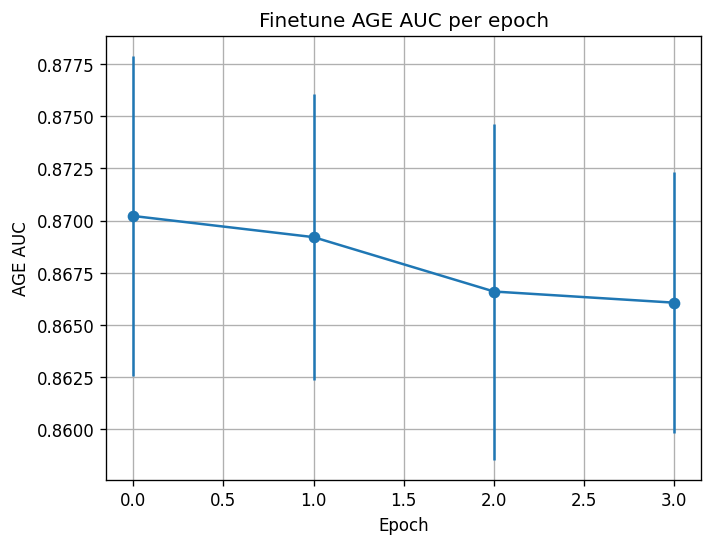

In [5]:
if fin_metrics:
    plot_auc_all(fin_metrics, title_prefix="Finetune")
else:
    print("Finetune JSON not found or empty.")


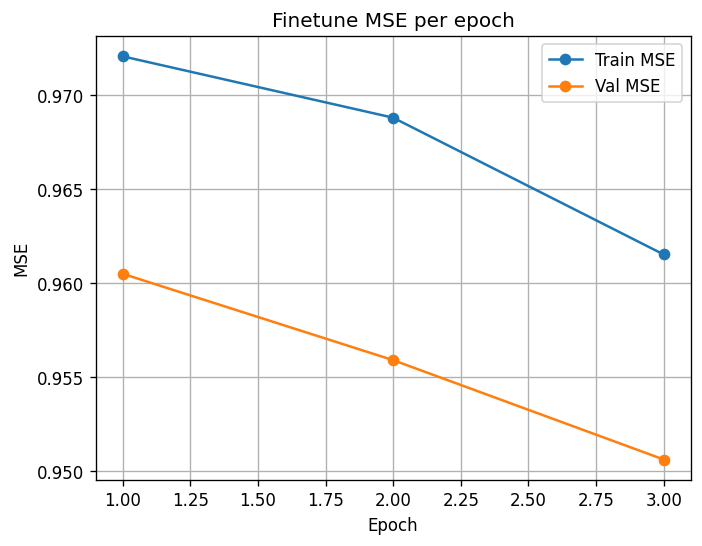

In [6]:
if fin_metrics:
    plot_mse(fin_metrics, is_finetune=True, title_prefix="Finetune")


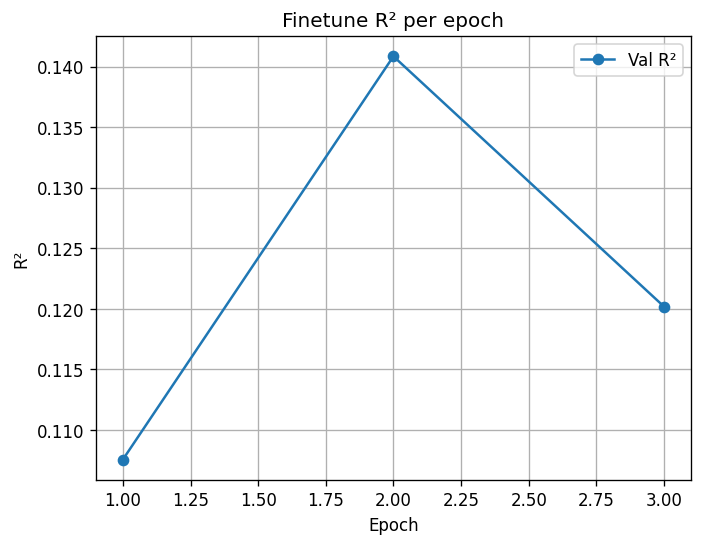

In [7]:
if fin_metrics:
    plot_r2(fin_metrics, title_prefix="Finetune")


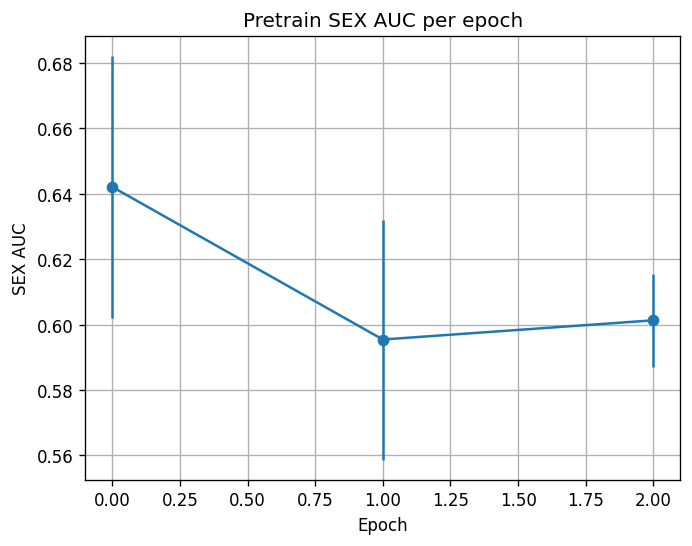

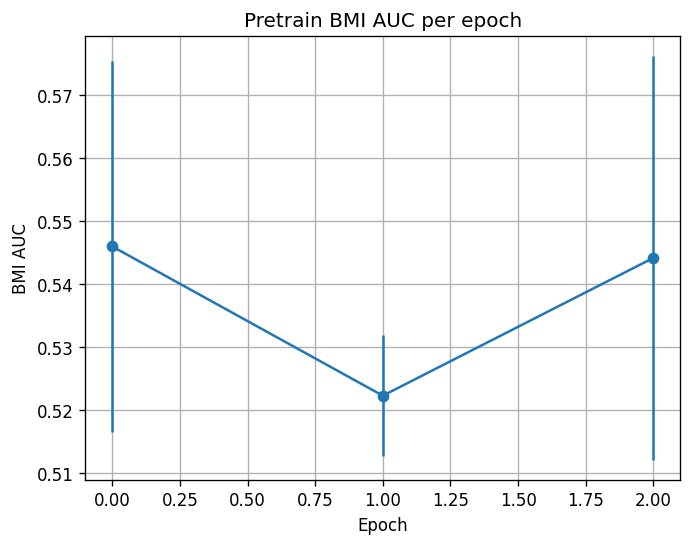

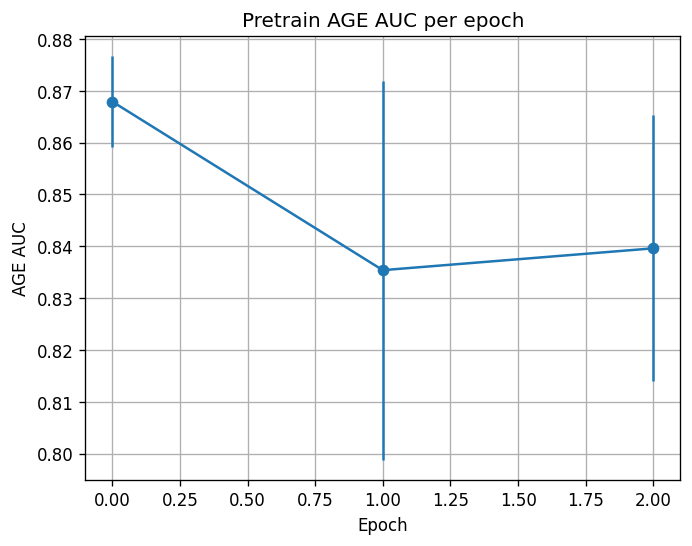

In [8]:
if pre_metrics:
    plot_auc_all(pre_metrics, title_prefix="Pretrain")
else:
    print("Pretrain JSON not found or empty.")


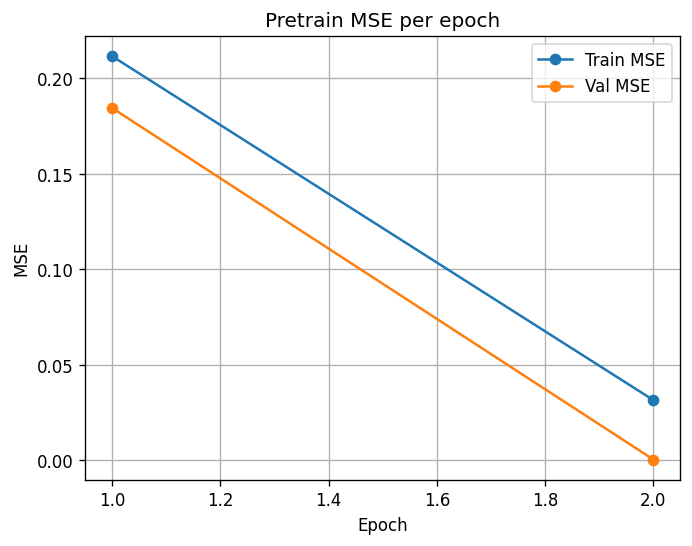

In [9]:
if pre_metrics:
    plot_mse(pre_metrics, is_finetune=False, title_prefix="Pretrain")


In [13]:
# pretrain_plots.py
import json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- paths (you're running from ./output) ---
JSON_PATH  = "retina_pretrain_epoch_metrics.json"
IMAGES_DIR = "images"
os.makedirs(IMAGES_DIR, exist_ok=True)
OUT_MSE = os.path.join(IMAGES_DIR, "pretrain_mse.png")
OUT_AUC = os.path.join(IMAGES_DIR, "pretrain_auc.png")

# ---- styling so axes/ticks are very visible ----
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 20,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "lines.linewidth": 2.5,
    "lines.markersize": 6,
})

# ---- load ----
with open(JSON_PATH, "r") as f:
    data = json.load(f)
df = pd.DataFrame(data)
df = df.drop_duplicates(subset=["epoch"], keep="last").sort_values("epoch").reset_index(drop=True)

# =========================
# 1) MSE plot
# =========================
mse_cols = [c for c in ["train_mse", "val_mse"] if c in df.columns]
mse_df = df[["epoch"] + mse_cols].dropna(how="all", subset=mse_cols)

fig, ax = plt.subplots()
if "train_mse" in mse_df:
    ax.plot(mse_df["epoch"], mse_df["train_mse"], marker="o", label="Train MSE")
if "val_mse" in mse_df:
    ax.plot(mse_df["epoch"], mse_df["val_mse"], marker="o", label="Val MSE")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.set_title("Pretraining - Train/Val MSE")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(OUT_MSE, dpi=220, bbox_inches="tight")
plt.close(fig)

# =========================
# 2) AUC plot (with error bars)
# =========================
metrics = {
    "Sex AUC": ("sex_auc", "sex_auc_std"),
    "BMI AUC": ("bmi_auc", "bmi_auc_std"),
    "Age AUC": ("age_auc", "age_auc_std"),
}

fig, ax = plt.subplots()
for label, (mean_col, std_col) in metrics.items():
    if mean_col in df.columns:
        sub = df[["epoch", mean_col, std_col] if std_col in df.columns else ["epoch", mean_col]].dropna(subset=[mean_col])
        yerr = sub[std_col].values if std_col in sub.columns and not sub[std_col].isna().all() else None
        ax.errorbar(sub["epoch"], sub[mean_col], yerr=yerr, capsize=3, marker="o", label=label)

ax.set_xlabel("Epoch")
ax.set_ylabel("AUC")
ax.set_title("Pretraining - Demographic AUC (5-fold)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(OUT_AUC, dpi=220, bbox_inches="tight")
plt.close(fig)

print(f"Saved:\n  - {os.path.abspath(OUT_MSE)}\n  - {os.path.abspath(OUT_AUC)}")


Saved:
  - /home/gavrielh/PycharmProjects/MSc_Thesis/JEPA/outputs/images/pretrain_mse.png
  - /home/gavrielh/PycharmProjects/MSc_Thesis/JEPA/outputs/images/pretrain_auc.png


In [15]:
# finetune_plots.py
import json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- paths (you're running from ./output) ---
JSON_PATH  = "retina_finetune_epoch_metrics.json"
IMAGES_DIR = "images"
os.makedirs(IMAGES_DIR, exist_ok=True)
OUT_MSE = os.path.join(IMAGES_DIR, "finetune_mse.png")
OUT_AUC = os.path.join(IMAGES_DIR, "finetune_auc.png")

# (optional) clamp plots to a max epoch (e.g., 7). Set to None to plot all.
MAX_EPOCH = None  # or 7

# ---- styling so axes/ticks are very visible ----
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 20,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
    "lines.linewidth": 2.5,
    "lines.markersize": 6,
})

# ---- load ----
with open(JSON_PATH, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
# Keep last entry per epoch in case of resumes, then sort
df = df.drop_duplicates(subset=["epoch"], keep="last").sort_values("epoch").reset_index(drop=True)

# optional clamp
if MAX_EPOCH is not None:
    df = df[df["epoch"] <= MAX_EPOCH].reset_index(drop=True)

# =========================
# 1) MSE plot
# =========================
mse_cols = [c for c in ["train_mse_mean", "val_mse_mean"] if c in df.columns]
mse_df = df[["epoch"] + mse_cols].dropna(how="all", subset=mse_cols)

fig, ax = plt.subplots()
if "train_mse_mean" in mse_df.columns and not mse_df["train_mse_mean"].isna().all():
    ax.plot(mse_df["epoch"], mse_df["train_mse_mean"], marker="o", label="Train MSE")
if "val_mse_mean" in mse_df.columns and not mse_df["val_mse_mean"].isna().all():
    ax.plot(mse_df["epoch"], mse_df["val_mse_mean"], marker="o", label="Val MSE")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.set_title("Finetuning - Train/Val MSE")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(OUT_MSE, dpi=220, bbox_inches="tight")
plt.close(fig)

# =========================
# 2) AUC plot (with error bars)
# =========================
metrics = {
    "Sex AUC": ("sex_auc", "sex_auc_std"),
    "BMI AUC": ("bmi_auc", "bmi_auc_std"),
    "Age AUC": ("age_auc", "age_auc_std"),
}

fig, ax = plt.subplots()
for label, (mean_col, std_col) in metrics.items():
    if mean_col in df.columns:
        cols = ["epoch", mean_col] + ([std_col] if std_col in df.columns else [])
        sub = df[cols].dropna(subset=[mean_col])
        if len(sub) == 0:
            continue
        yerr = (
            sub[std_col].values
            if std_col in sub.columns and not sub[std_col].isna().all()
            else None
        )
        ax.errorbar(sub["epoch"], sub[mean_col], yerr=yerr, capsize=3, marker="o", label=label)

ax.set_xlabel("Epoch")
ax.set_ylabel("AUC")
ax.set_title("Finetuning - Demographic AUC (5-fold)")
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig(OUT_AUC, dpi=220, bbox_inches="tight")
plt.close(fig)

print(f"Saved:\n  - {os.path.abspath(OUT_MSE)}\n  - {os.path.abspath(OUT_AUC)}")


Saved:
  - /home/gavrielh/PycharmProjects/MSc_Thesis/JEPA/outputs/images/finetune_mse.png
  - /home/gavrielh/PycharmProjects/MSc_Thesis/JEPA/outputs/images/finetune_auc.png


In [17]:
# --- paths (run from ./output) ---
JSON_PATH  = "retina_finetune_epoch_metrics.json"
IMAGES_DIR = "images"
os.makedirs(IMAGES_DIR, exist_ok=True)
OUT_MSE = os.path.join(IMAGES_DIR, "finetune_top5_val_mse.png")
OUT_R2  = os.path.join(IMAGES_DIR, "finetune_top5_val_r2.png")

# --- styling (clear, high-contrast) ---
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 20,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 12,
    "lines.linewidth": 2.0,
    "lines.markersize": 6,
})

# --- load JSON robustly ---
try:
    with open(JSON_PATH, "r") as f:
        data = json.load(f)
    if not isinstance(data, list):
        raise ValueError("Metrics JSON is not a list of epoch entries.")
except (FileNotFoundError, JSONDecodeError, ValueError) as e:
    raise SystemExit(f"Failed reading {JSON_PATH}: {e}")

df = pd.DataFrame(data)

# keep last entry if duplicate epochs exist, sort, and filter epochs >= 1
if "epoch" not in df.columns:
    raise SystemExit("Metrics JSON has no 'epoch' field.")
df = df.drop_duplicates(subset=["epoch"], keep="last").sort_values("epoch").reset_index(drop=True)
df = df[df["epoch"].astype(float) >= 1].copy()

# --- collect union of features that ever appear in top5 after epoch 0 ---
feature_set = set()
epoch_rows = {}
for _, row in df.iterrows():
    ep = int(row["epoch"])
    top5 = row.get("top5_features_by_val_mse", []) or []
    epoch_rows[ep] = top5
    for item in top5:
        feat = item.get("feature")
        if isinstance(feat, str) and feat:
            feature_set.add(feat)

if not feature_set:
    raise SystemExit("No 'top5_features_by_val_mse' entries found for epochs >= 1.")

features = sorted(feature_set)
epochs   = sorted(epoch_rows.keys())

# --- build per-feature series over epochs for val_mse and val_r2 ---
val_mse_map = {feat: [] for feat in features}
val_r2_map  = {feat: [] for feat in features}

for ep in epochs:
    top5 = epoch_rows.get(ep, [])
    # index by feature for quick lookup
    lookup = {d.get("feature"): d for d in top5 if isinstance(d, dict)}
    for feat in features:
        entry = lookup.get(feat)
        if entry is None:
            val_mse_map[feat].append(np.nan)
            val_r2_map[feat].append(np.nan)
        else:
            val_mse_map[feat].append(entry.get("val_mse", np.nan))
            val_r2_map[feat].append(entry.get("val_r2", np.nan))

# --- helper to plot a multi-line chart with legend to the right ---
def plot_multiline(epochs, series_dict, ylabel, title, outfile):
    fig, ax = plt.subplots()
    for feat, vals in series_dict.items():
        ax.plot(epochs, vals, marker="o", label=feat)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # park legend outside on the right (and keep tight bbox so it isn't clipped)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    fig.tight_layout()
    fig.savefig(outfile, dpi=220, bbox_inches="tight")
    plt.close(fig)

# --- plot and save ---
plot_multiline(epochs, val_mse_map, ylabel="Val MSE",
               title="Finetune - Top-5 Features by Val MSE (only when in top-5)",
               outfile=OUT_MSE)

plot_multiline(epochs, val_r2_map, ylabel="Val R²",
               title="Finetune - Top-5 Features Val R² (only when in top-5)",
               outfile=OUT_R2)

print("Saved:")
print(" -", os.path.abspath(OUT_MSE))
print(" -", os.path.abspath(OUT_R2))

Saved:
 - /home/gavrielh/PycharmProjects/MSc_Thesis/JEPA/outputs/images/finetune_top5_val_mse.png
 - /home/gavrielh/PycharmProjects/MSc_Thesis/JEPA/outputs/images/finetune_top5_val_r2.png
